# 1) Evaluasi RAG vs Non-RAG

- **RAG** (menggunakan ChromaDB + konteks)
- **Non-RAG** (baseline LLM tanpa konteks)

Metrik:
- **Precision**
- **Recall** 
- **F1**
- **Semantic Similarity**


In [1]:
# 1) Install / import library
!pip -q install pandas numpy requests sentence-transformers huggingface-hub python-dotenv

import os
import re
import string
import requests
import numpy as np
import pandas as pd
from collections import Counter

from dotenv import load_dotenv
load_dotenv()



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


True

## 2) Ground Truth QnA



In [2]:
qa_pairs = [
    {"question": "Berapa syarat TOEFL program doktor?", "answer": "Skor TOEFL minimal untuk Program Doktor ITS adalah 500."},
    {"question": "Berapa biaya kuliah magister reguler?", "answer": "Biaya kuliah per semester untuk Program Magister jalur Reguler adalah Rp 12.500.000,-."},
    {"question": "Apa saja syarat pendaftaran program magister jalur riset?", "answer": "Lulus sarjana dari program studi yang terakreditasi minimal B dengan IPK ≥ 3,25 atau akreditasi A dengan IPK ≥ 3,00, Tes potensi kemampuan akademik (TPKA) (minimal 475), TEFL atau yang setara (minimal 477), tes materi bidang (minimal 66), dan wawancara (minimal 66), Mempunyai 1 (satu) publikasi ilmiah dalam 5 tahun terakhir yang dipublikasikan dalam prosiding seminar internasional bereputasi jurnal nasional terakreditasi, Nilai Tugas Akhir atau Skripsi adalah A"},
    {"question": "Berapa beban studi sks pada program Magister ITS?", "answer": "Program Magister di ITS umumnya menempuh beban kredit sekitar 36–50 SKS, tergantung program studi."},
    {"question": "Apa yang dimaksud dengan skema Program Magister Skema Kerjasama?", "answer": "Program Magister kerjasama ITS dengan instansi atau perusahan dalam negeri."},
    {"question": "Apa saja syarat Beasiswa  Fastrack program Magister?", "answer": "Mahasiswa akhir semester 6 yang sudah lulus minimal 120 sks, IPK minimal 3.25, TOEFL minimal 475."},
    {"question": "Kapan jadwal pendaftaran mahasiswa baru Pascasarjana ITS Semester Genap 2025/2026?", "answer": "Pendaftaran dibuka mulai 06 Oktober – 29 Desember 2025."},
    {"question": "Apa saja beasiswa yang ditawarkan pada program magister ITS?", "answer": "Beasiswa Freshgraduate, Beasiswa Penelitian Dosen, Beasiswa Fast Track, Beasiswa Fast-D ITS."},
    {"question": "Berapa syarat TOEFL program magister?", "answer": "Skor TOEFL minimal untuk Program Magister ITS adalah 477."},
    {"question": "Berapa biaya kuliah magister jalur reguler?", "answer": "Biaya magister jalur reguler adalah Rp 12.500.000 per semester"}
]
# len(qa_pairs), qa_pairs[:10]


## 3) Definisi metrik token-level

In [3]:
def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.lower()
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize(s: str):
    s = normalize_text(s)
    return [] if not s else s.split()

def precision_recall_f1(expected: str, generated: str):
    exp_tokens = tokenize(expected)
    gen_tokens = tokenize(generated)

    if len(gen_tokens) == 0 and len(exp_tokens) == 0:
        return 1.0, 1.0, 1.0
    if len(gen_tokens) == 0 or len(exp_tokens) == 0:
        return 0.0, 0.0, 0.0

    exp_c = Counter(exp_tokens)
    gen_c = Counter(gen_tokens)
    overlap = sum((exp_c & gen_c).values())

    prec = overlap / max(len(gen_tokens), 1)
    rec  = overlap / max(len(exp_tokens), 1)
    f1 = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec)
    return prec, rec, f1

def exact_match(expected: str, generated: str) -> int:
    return int(normalize_text(expected) == normalize_text(generated))


## 4) Semantic Similarity

Model:
- `sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2`


In [ ]:
USE_SEMANTIC_SIM = True


HF_TOKEN = os.getenv("HF_TOKEN")
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

embedder = None
if USE_SEMANTIC_SIM:
    from sentence_transformers import SentenceTransformer
    embedder = SentenceTransformer(MODEL_NAME, use_auth_token=HF_TOKEN)
    print("Loaded embedder:", MODEL_NAME)
else:
    print("Semantic similarity disabled.")


c:\Users\YOGA\llm_chatbot\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded embedder: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2


In [ ]:
def semantic_similarity(expected: str, generated: str) -> float:
    if embedder is None:
        return np.nan
    embs = embedder.encode([expected, generated], normalize_embeddings=True)
    return float(np.dot(embs[0], embs[1])) 


## 5) Panggil API Chatbot (RAG vs Non-RAG)

Pastikan server jalan:
```bash
uvicorn main:app --reload
```

pakai:
- `POST /chat` dengan `{"query": "...", "mode": "rag"}` atau `"non_rag"`


In [6]:
BASE_URL = "http://localhost:8000"
CHAT_ENDPOINT = f"{BASE_URL}/chat"

def call_chat_api(question: str, mode: str):
    payload = {"query": question, "mode": mode}
    r = requests.post(CHAT_ENDPOINT, json=payload, timeout=60)
    r.raise_for_status()
    data = r.json()
    # Expect: {"answer": "...", "sources": [...], "mode": "..."}
    return data.get("answer", ""), data.get("sources", [])

# test
try:
    ans, src = call_chat_api("Halo", mode="rag")
    print("RAG OK:", ans[:120], "...")
    ans2, _ = call_chat_api("Halo", mode="non_rag")
    print("NON-RAG OK:", ans2[:120], "...")
except Exception as e:
    print("Gagal panggil API. Pastikan FastAPI berjalan di", CHAT_ENDPOINT)
    print("Error:", repr(e))


RAG OK: Maaf, informasi tersebut tidak tersedia dalam dokumen resmi yang saya miliki. ...
NON-RAG OK: Halo! Ada yang bisa saya bantu? ...


## 6A) Evaluasi MODE: RAG

In [ ]:
F1_THRESHOLD = 0.80
SEM_THRESHOLD = 0.75 

def evaluate_mode(mode: str) -> pd.DataFrame:
    rows = []
    for item in qa_pairs:
        q = str(item["question"])
        expected = str(item["answer"])

        generated, sources = call_chat_api(q, mode=mode)

        p, r, f1 = precision_recall_f1(expected, generated)
        em = exact_match(expected, generated)
        sem = semantic_similarity(expected, generated) if USE_SEMANTIC_SIM else np.nan

        acc = int((em == 1) or (f1 >= F1_THRESHOLD) or (USE_SEMANTIC_SIM and (sem >= SEM_THRESHOLD)))

        rows.append({
            "mode": mode,
            "question": q,
            "expected_answer": expected,
            "generated_answer": generated,
            "precision": round(p, 4),
            "recall": round(r, 4),
            "f1": round(f1, 4),
            "semantic_similarity": (None if np.isnan(sem) else round(float(sem), 4)),
            "answer_accuracy": acc,
            "sources_count": len(sources),
        })
    return pd.DataFrame(rows)

df_rag = evaluate_mode("rag")
df_rag


,mode,question,expected_answer,generated_answer,precision,recall,f1,semantic_similarity,answer_accuracy,sources_count
0,rag,Berapa syarat TOEFL program doktor?,Skor TOEFL minimal untuk Program Doktor ITS ad...,Skor TOEFL minimal untuk Program Doktor ITS ad...,1.0000,1.0000,1.0000,1.0000,1,5
1,rag,Berapa biaya kuliah magister reguler?,Biaya kuliah per semester untuk Program Magist...,Biaya kuliah untuk Program Magister Jalur Regu...,0.8571,1.0000,0.9231,0.9719,1,5
2,rag,Apa saja syarat pendaftaran program magister j...,Lulus sarjana dari program studi yang terakred...,Syarat pendaftaran Program Magister jalur rise...,0.5000,0.2794,0.3585,0.6901,0,5
3,rag,Berapa beban studi sks pada program Magister ITS?,Program Magister di ITS umumnya menempuh beban...,Beban studi SKS pada program Magister ITS adal...,0.3333,0.4286,0.3750,0.6687,0,5
4,rag,Apa yang dimaksud dengan skema Program Magiste...,Program Magister kerjasama ITS dengan instansi...,Program Magister Skema Kerjasama adalah progra...,0.5625,0.9000,0.6923,0.8312,1,5
5,rag,Apa saja syarat Beasiswa Fastrack program Mag...,Mahasiswa akhir semester 6 yang sudah lulus mi...,Syarat Beasiswa Fast-Track Program Magister IT...,0.6087,0.8750,0.7179,0.7231,0,5
6,rag,Kapan jadwal pendaftaran mahasiswa baru Pascas...,Pendaftaran dibuka mulai 06 Oktober – 29 Desem...,Jadwal pendaftaran mahasiswa baru Pascasarjana...,0.1556,0.7778,0.2593,0.6287,0,5
7,rag,Apa saja beasiswa yang ditawarkan pada program...,"Beasiswa Freshgraduate, Beasiswa Penelitian Do...",Beasiswa yang ditawarkan pada program Magister...,0.3000,0.5455,0.3871,0.7490,0,5
8,rag,Berapa syarat TOEFL program magister?,Skor TOEFL minimal untuk Program Magister ITS ...,Skor TOEFL minimal untuk Program Magister ITS ...,1.0000,1.0000,1.0000,1.0000,1,5
9,rag,Berapa biaya kuliah magister jalur reguler?,Biaya magister jalur reguler adalah Rp 12.500....,Biaya kuliah untuk Program Magister jalur regu...,0.6429,1.0000,0.7826,0.9522,1,5


## 6B) Evaluasi MODE: Non-RAG

In [ ]:
# Metode Non-RAG
df_nonrag = evaluate_mode("non_rag")
df_nonrag


,mode,question,expected_answer,generated_answer,precision,recall,f1,semantic_similarity,answer_accuracy,sources_count
0,non_rag,Berapa syarat TOEFL program doktor?,Skor TOEFL minimal untuk Program Doktor ITS ad...,Skor TOEFL minimal untuk Program Doktor ITS ad...,1.0000,1.0000,1.0000,1.0000,1,0
1,non_rag,Berapa biaya kuliah magister reguler?,Biaya kuliah per semester untuk Program Magist...,"Maaf, informasi tersebut tidak diketahui.",0.0000,0.0000,0.0000,0.0187,0,0
2,non_rag,Apa saja syarat pendaftaran program magister j...,Lulus sarjana dari program studi yang terakred...,1. Gelar Sarjana atau setara.\n2. IPK minimal ...,0.7778,0.1029,0.1818,0.5431,0,0
3,non_rag,Berapa beban studi sks pada program Magister ITS?,Program Magister di ITS umumnya menempuh beban...,Beban studi SKS pada program Magister ITS berk...,0.5455,0.4286,0.4800,0.7720,1,0
4,non_rag,Apa yang dimaksud dengan skema Program Magiste...,Program Magister kerjasama ITS dengan instansi...,"Maaf, informasi tersebut tidak diketahui.",0.0000,0.0000,0.0000,0.0602,0,0
5,non_rag,Apa saja syarat Beasiswa Fastrack program Mag...,Mahasiswa akhir semester 6 yang sudah lulus mi...,"Maaf, informasi tersebut tidak diketahui.",0.0000,0.0000,0.0000,0.0668,0,0
6,non_rag,Kapan jadwal pendaftaran mahasiswa baru Pascas...,Pendaftaran dibuka mulai 06 Oktober – 29 Desem...,"Maaf, informasi tersebut tidak diketahui.",0.0000,0.0000,0.0000,0.0228,0,0
7,non_rag,Apa saja beasiswa yang ditawarkan pada program...,"Beasiswa Freshgraduate, Beasiswa Penelitian Do...","Maaf, informasi tersebut tidak diketahui.",0.0000,0.0000,0.0000,0.0901,0,0
8,non_rag,Berapa syarat TOEFL program magister?,Skor TOEFL minimal untuk Program Magister ITS ...,Skor TOEFL minimal untuk Program Magister di I...,0.8000,0.8889,0.8421,0.8179,1,0
9,non_rag,Berapa biaya kuliah magister jalur reguler?,Biaya magister jalur reguler adalah Rp 12.500....,"Maaf, informasi tersebut tidak diketahui.",0.0000,0.0000,0.0000,-0.0044,0,0


## 7) Gabungan RAG vs Non-RAG

In [ ]:
# Gabung
df_all = pd.concat([df_rag, df_nonrag], ignore_index=True)
df_all


,mode,question,expected_answer,generated_answer,precision,recall,f1,semantic_similarity,answer_accuracy,sources_count
0,rag,Berapa syarat TOEFL program doktor?,Skor TOEFL minimal untuk Program Doktor ITS ad...,Skor TOEFL minimal untuk Program Doktor ITS ad...,1.0000,1.0000,1.0000,1.0000,1,5
1,rag,Berapa biaya kuliah magister reguler?,Biaya kuliah per semester untuk Program Magist...,Biaya kuliah untuk Program Magister Jalur Regu...,0.8571,1.0000,0.9231,0.9719,1,5
2,rag,Apa saja syarat pendaftaran program magister j...,Lulus sarjana dari program studi yang terakred...,Syarat pendaftaran Program Magister jalur rise...,0.5000,0.2794,0.3585,0.6901,0,5
3,rag,Berapa beban studi sks pada program Magister ITS?,Program Magister di ITS umumnya menempuh beban...,Beban studi SKS pada program Magister ITS adal...,0.3333,0.4286,0.3750,0.6687,0,5
4,rag,Apa yang dimaksud dengan skema Program Magiste...,Program Magister kerjasama ITS dengan instansi...,Program Magister Skema Kerjasama adalah progra...,0.5625,0.9000,0.6923,0.8312,1,5
5,rag,Apa saja syarat Beasiswa Fastrack program Mag...,Mahasiswa akhir semester 6 yang sudah lulus mi...,Syarat Beasiswa Fast-Track Program Magister IT...,0.6087,0.8750,0.7179,0.7231,0,5
6,rag,Kapan jadwal pendaftaran mahasiswa baru Pascas...,Pendaftaran dibuka mulai 06 Oktober – 29 Desem...,Jadwal pendaftaran mahasiswa baru Pascasarjana...,0.1556,0.7778,0.2593,0.6287,0,5
7,rag,Apa saja beasiswa yang ditawarkan pada program...,"Beasiswa Freshgraduate, Beasiswa Penelitian Do...",Beasiswa yang ditawarkan pada program Magister...,0.3000,0.5455,0.3871,0.7490,0,5
8,rag,Berapa syarat TOEFL program magister?,Skor TOEFL minimal untuk Program Magister ITS ...,Skor TOEFL minimal untuk Program Magister ITS ...,1.0000,1.0000,1.0000,1.0000,1,5
9,rag,Berapa biaya kuliah magister jalur reguler?,Biaya magister jalur reguler adalah Rp 12.500....,Biaya kuliah untuk Program Magister jalur regu...,0.6429,1.0000,0.7826,0.9522,1,5


In [ ]:
# Ringkasan rata-rata per mode
def summarize(df: pd.DataFrame) -> pd.DataFrame:
    out = df.groupby("mode").agg(
        avg_precision=("precision", "mean"),
        avg_recall=("recall", "mean"),
        avg_f1=("f1", "mean"),
        accuracy_rate=("answer_accuracy", "mean"),
        avg_semantic_similarity=("semantic_similarity", lambda s: pd.to_numeric(s, errors="coerce").dropna().mean()),
        avg_sources_count=("sources_count", "mean"),
    ).reset_index()
    return out.round(4)

df_summary = summarize(df_all)
df_summary


,mode,avg_precision,avg_recall,avg_f1,accuracy_rate,avg_semantic_similarity,avg_sources_count
0,non_rag,0.3123,0.2420,0.2504,0.3,0.3387,0.0
1,rag,0.5960,0.7806,0.6496,0.5,0.8215,5.0


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


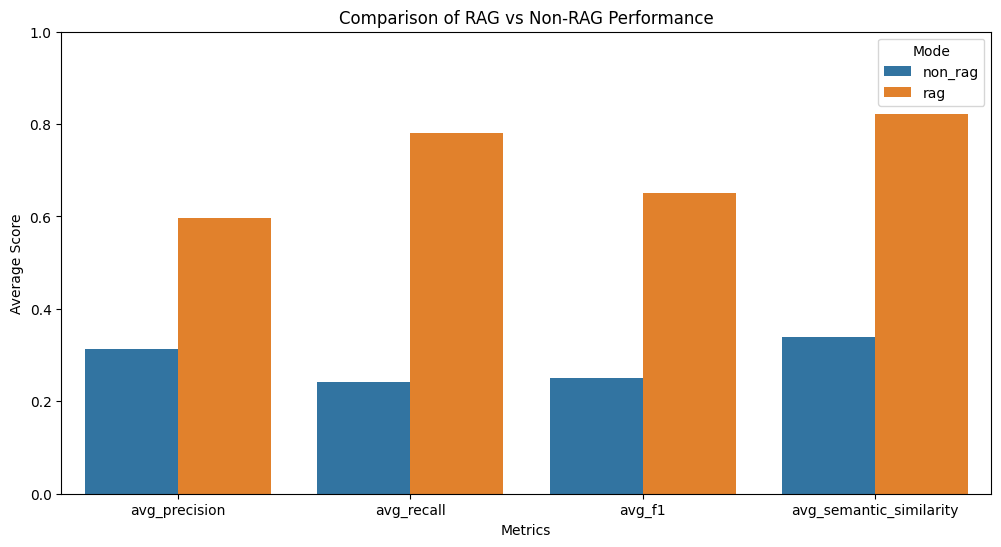

In [ ]:
# make chart to visualize
%pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
metrics = ["avg_precision", "avg_recall", "avg_f1", "avg_semantic_similarity"]
df_melted = df_summary.melt(id_vars="mode", value_vars=metrics, var_name="metric", value_name="value")
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="metric", y="value", hue="mode")
plt.title("Comparison of RAG vs Non-RAG Performance")
plt.ylabel("Average Score")
plt.xlabel("Metrics")
plt.ylim(0, 1)
plt.legend(title="Mode")
plt.show()


## 8) Simpan hasil

In [ ]:
from pathlib import Path

# Path("eval_results_rag.csv").write_text(df_rag.to_csv(index=False), encoding="utf-8")
# Path("eval_results_nonrag.csv").write_text(df_nonrag.to_csv(index=False), encoding="utf-8")
# Path("eval_results_all.csv").write_text(df_all.to_csv(index=False), encoding="utf-8")
# Path("eval_summary.csv").write_text(df_summary.to_csv(index=False), encoding="utf-8")

# print("Saved: eval_results_rag.csv, eval_results_nonrag.csv, eval_results_all.csv, eval_summary.csv")


2648